In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import jax
import jax.numpy as jnp
from jax.example_libraries.optimizers import adam
from jax.example_libraries import stax
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras_tuner as kt

## Read data

In [2]:
df = pd.read_parquet('./IDS2017/Final/Friday.parquet')
print(df['Label'].value_counts())

Label
DDoS      128014
BENIGN     95068
Name: count, dtype: int64


# Random Forest Classifier

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18954
           1       1.00      1.00      1.00     25663

    accuracy                           1.00     44617
   macro avg       1.00      1.00      1.00     44617
weighted avg       1.00      1.00      1.00     44617



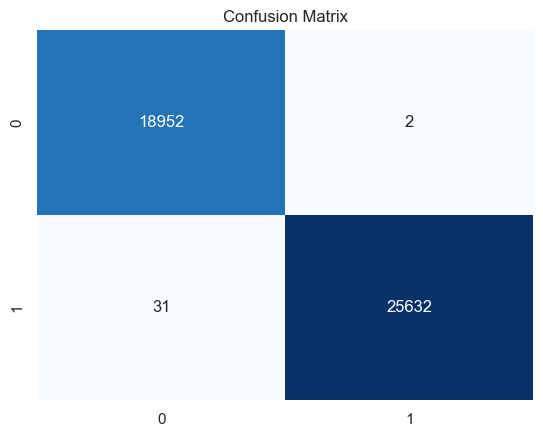

Accuracy Score:
0.9992603716072349


In [18]:
# Preprocess the data
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

# Split the dataset
X = df.drop('Label', axis=1)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = RandomForestClassifier(n_estimators=100)

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), fmt="d", annot=True, cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.show()

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

# K-Means

In [20]:
# Drop the 'Label' column
df = df.drop('Label', axis=1)

# Normalize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Initialize the KMeans model
kmeans = KMeans(n_clusters=2, random_state=42)

# Train the model
kmeans.fit(df_scaled)

# Predict the clusters
df['Cluster'] = kmeans.predict(df_scaled)

# Display the results
print(df['Cluster'].value_counts())

Cluster
1    140330
0     82752
Name: count, dtype: int64


# Isolation Forest

In [22]:
# Drop the 'Label' column
df = df.drop('Label', axis=1)

# Scale the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)

# Create the Isolation Forest model
model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)

# Train the model
model.fit(data_scaled)

# Detect anomalies
anomaly_scores = model.decision_function(data_scaled)
anomalies = model.predict(data_scaled)

# Add the results to the original data
df['anomaly_score'] = anomaly_scores
df['anomaly'] = anomalies

# Print the results
print("Anomaly detection results:")
print(df[['anomaly_score', 'anomaly']])

# Print detailed information about the anomalies
anomalies_data = df[df['anomaly'] == -1]
print("\nDetails of detected anomalies:")
print(anomalies_data)

Anomaly detection results:
        anomaly_score  anomaly
0            0.302715        1
1            0.295070        1
2            0.295070        1
3            0.295070        1
4            0.302715        1
...               ...      ...
223077       0.295070        1
223078       0.295070        1
223079       0.295070        1
223080       0.302715        1
223081       0.295070        1

[223082 rows x 2 columns]

Details of detected anomalies:
        Total Length of Fwd Packets  Total Length of Bwd Packets  \
109                            2728                         6634   
111                            1325                       108751   
112                            1325                       110185   
113                            1325                       108751   
114                            1313                       100063   
...                             ...                          ...   
222557                         5432                         6996  

# Autoencoder

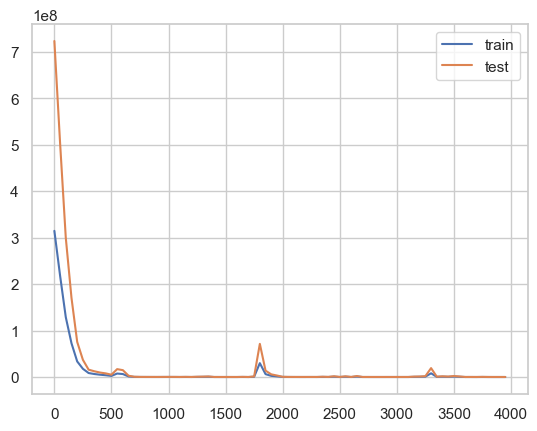

In [24]:
df = df.drop('Label', axis=1)
x = df.to_numpy()  

def vector_mse(y,yhat):
    return jnp.mean(jnp.square(y-yhat), axis=-1)

batch_size = 256
steps = 4000 
learning_rate = 0.001
train_split = int(0.7*x.shape[0])

k = jax.random.PRNGKey(42)

encoder = stax.serial(
    stax.Dense(16),
    stax.Relu,
    stax.Dense(8)
)

decoder = stax.serial(
    stax.Dense(16),
    stax.Relu,
    stax.Dense(x.shape[1])
)

nn = stax.serial(encoder, decoder)

init_nn, apply_nn = nn
opt_init, opt_update, get_params = adam(learning_rate)



@jax.jit 
def step(i, opt_state, x,y):
  params = get_params(opt_state)

  def loss(params,x,y):
      reconstruction = apply_nn(params,x) 
      return jnp.mean(vector_mse(y,reconstruction))

  g = jax.grad(loss)(params, x,y) 
  opt_state = opt_update(i, g, opt_state)
  step_loss = loss(get_params(opt_state),x,y)
  return opt_state, step_loss

@jax.jit
def test_loss(opt_state,x,y):
    params = get_params(opt_state) 
    reconstruction = apply_nn(params,x) 
    return jnp.mean(vector_mse(y,reconstruction))

_,params  = init_nn(k,(batch_size,x.shape[1])) 
opt_state = opt_init(params)

losses = []
test_losses = []
train_steps = []

for i in range(steps):
    idx = np.random.randint(0, train_split, size=batch_size)
    bx = x[idx,...]

    opt_state, step_loss = step(i, opt_state,bx,bx) 

    if i % 50 == 0:
        tx = x[train_split:,...]
        test_losses.append(test_loss(opt_state,tx,tx))
        train_steps.append(i) 
        losses.append(test_loss(opt_state,x[:train_split,...],x[:train_split,...]))

plt.plot(train_steps,losses,label='train')
plt.plot(train_steps,test_losses,label='test')
 
plt.legend()

# Neural Network

### Tuner

In [5]:
# Preprocess the data
df['Label'] = df['Label'].apply(lambda x: 1 if x == 'BENIGN' else 0).astype("int")  # BENIGN -> 1, non-BENIGN -> 0
df['Bwd Packet Length Max'] = df['Bwd Packet Length Max'].astype('int')

# Split the dataset
X = df.drop('Label', axis=1)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the model building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=8, max_value=64, step=8), 
                    input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(units=hp.Int('units_2', min_value=4, max_value=32, step=4), 
                    activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Set up the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='my_dir',
    project_name='network_anomaly_detection'
)

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=10, validation_split=0.2, batch_size=128)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
best_model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.3)

# Evaluate the model
loss, accuracy = best_model.evaluate(X_test, y_test)
print('Test accuracy: %.2f' % (accuracy * 100))

Trial 20 Complete [00h 00m 18s]
val_accuracy: 0.9835745394229889

Best val_accuracy So Far: 0.9939485192298889
Total elapsed time: 00h 13m 31s
Epoch 1/10
854/854 ━━━━━━━━━━━━━━━━━━━━ 2s 962us/step - accuracy: 0.9338 - loss: 0.1601 - val_accuracy: 0.9911 - val_loss: 0.0597
Epoch 2/10
854/854 ━━━━━━━━━━━━━━━━━━━━ 1s 838us/step - accuracy: 0.9845 - loss: 0.0600 - val_accuracy: 0.9907 - val_loss: 0.0463
Epoch 3/10
854/854 ━━━━━━━━━━━━━━━━━━━━ 1s 847us/step - accuracy: 0.9883 - loss: 0.0487 - val_accuracy: 0.9903 - val_loss: 0.0434
Epoch 4/10
854/854 ━━━━━━━━━━━━━━━━━━━━ 1s 895us/step - accuracy: 0.9883 - loss: 0.0464 - val_accuracy: 0.9880 - val_loss: 0.0425
Epoch 5/10
854/854 ━━━━━━━━━━━━━━━━━━━━ 1s 865us/step - accuracy: 0.9862 - loss: 0.0536 - val_accuracy: 0.9849 - val_loss: 0.0514
Epoch 6/10
854/854 ━━━━━━━━━━━━━━━━━━━━ 1s 837us/step - accuracy: 0.9872 - loss: 0.0518 - val_accuracy: 0.9880 - val_loss: 0.0539
Epoch 7/10
854/854 ━━━━━━━━━━━━━━━━━━━━ 1s 857us/step - accuracy: 0.9888 - lo

### Model

Epoch 1/3


c:\Users\delve\WebstormProjects\ids2018-anomaly-detection\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1220/1220 ━━━━━━━━━━━━━━━━━━━━ 2s 903us/step - accuracy: 0.7765 - loss: 0.4165 - val_accuracy: 0.9774 - val_loss: 0.0840
Epoch 2/3
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 1s 809us/step - accuracy: 0.9804 - loss: 0.0740 - val_accuracy: 0.9881 - val_loss: 0.0555
Epoch 3/3
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 1s 798us/step - accuracy: 0.9872 - loss: 0.0539 - val_accuracy: 0.9882 - val_loss: 0.0469
2092/2092 ━━━━━━━━━━━━━━━━━━━━ 1s 455us/step - accuracy: 0.9884 - loss: 0.0480
Test accuracy: 98.82


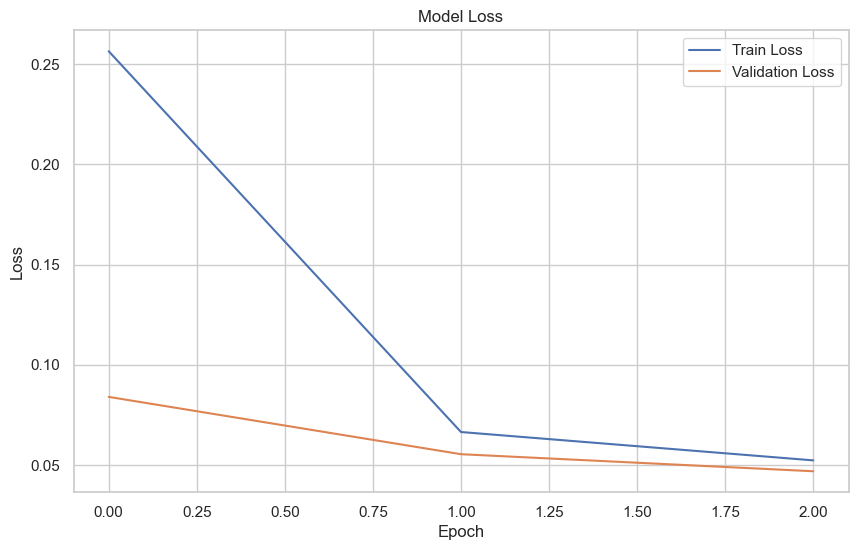

In [3]:
# Preprocess the data
df['Label'] = df['Label'].apply(lambda x: 1 if x == 'BENIGN' else 0).astype("int")  # BENIGN -> 1, non-BENIGN -> 0
df['Bwd Packet Length Max'] = df['Bwd Packet Length Max'].astype('int')

# Split the dataset
X = df.drop('Label', axis=1)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = Sequential()
model.add(Dense(18, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=3,
    batch_size=128,
    validation_data=(X_test_scaled, y_test)
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print('Test accuracy: %.2f' % (accuracy*100))

# Plotting the loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

### Read bigger dataset

In [5]:
df_big = pd.read_parquet('./IDS2017/Final/Combined.parquet')
df_big['Label'] = df_big['Label'].apply(lambda x: 1 if x == 'BENIGN' else 0).astype(int)  # BENIGN -> 1, non-BENIGN -> 0
df_big['Bwd Packet Length Max'] = df_big['Bwd Packet Length Max'].astype('int')
print(df_big['Label'].value_counts())

Label
1    1014454
0     321770
Name: count, dtype: int64


### Threshhold setter

41757/41757 ━━━━━━━━━━━━━━━━━━━━ 21s 511us/step
Best Threshold: 0.751001001001001
Maximum Accuracy: 0.9033844624853318
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.83      0.81    321770
           1       0.95      0.93      0.94   1014454

    accuracy                           0.90   1336224
   macro avg       0.86      0.88      0.87   1336224
weighted avg       0.91      0.90      0.90   1336224



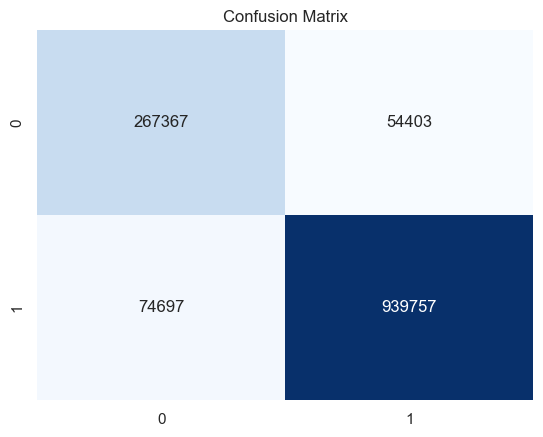

Accuracy Score:
0.9033844624853318


In [5]:
X_combined = df_big.drop('Label', axis=1)
y_combined = df_big['Label']
X_combined_scaled = scaler.transform(X_combined)

# Use the trained model to predict the labels of the new data
df_big['anomaly_score'] = model.predict(X_combined_scaled)

# Define the range of possible threshold values
thresholds = np.linspace(0.75, 1, 1000)
max_accuracy = 0 
best_threshold = 0

# Iterate over the possible threshold values
for threshold in thresholds:
    df_big['anomaly'] = df_big['anomaly_score'].apply(lambda x: 0 if x < threshold else 1)
    accuracy = accuracy_score(y_combined, df_big['anomaly'])

    if accuracy > max_accuracy:
        max_accuracy = accuracy
        best_threshold = threshold


print("Best Threshold:", best_threshold)
print("Maximum Accuracy:", max_accuracy)

df_big['anomaly'] = df_big['anomaly_score'].apply(lambda x: 0 if x < best_threshold else 1)

print("Classification Report:")
print(classification_report(y_combined, df_big['anomaly']))

sns.heatmap(confusion_matrix(y_combined, df_big['anomaly']), fmt="d", annot=True, cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.show()

print("Accuracy Score:")
print(accuracy_score(y_combined, df_big['anomaly']))

### Check model

41757/41757 ━━━━━━━━━━━━━━━━━━━━ 19s 465us/step
anomaly
1    1077377
0     258847
Name: count, dtype: int64
2.3215393e-18 1.0
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.76      0.84    321770
           1       0.93      0.98      0.95   1014454

    accuracy                           0.93   1336224
   macro avg       0.93      0.87      0.90   1336224
weighted avg       0.93      0.93      0.93   1336224



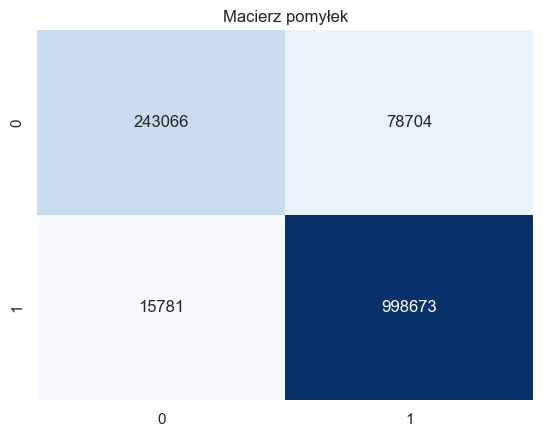

Accuracy Score:
0.929289550255047


In [6]:
X_combined = df_big.drop('Label', axis=1)
y_combined = df_big['Label']

# Define the scaler
scaler = StandardScaler()
scaler.fit(X_combined)

# Normalize the data
X_combined_scaled = scaler.transform(X_combined)

# Use the trained model to predict the labels of the new data
df_big['anomaly_score'] = model.predict(X_combined_scaled)

threshold = 0.77

df_big['anomaly'] = df_big['anomaly_score'].apply(lambda x: 0 if x < threshold else 1)

print(df_big['anomaly'].value_counts())
print(df_big['anomaly_score'].min(), df_big['anomaly_score'].max())

# Compare the predicted labels with the actual labels
print("Classification Report:")
print(classification_report(y_combined, df_big['anomaly']))

sns.heatmap(confusion_matrix(y_combined, df_big['anomaly']), fmt="d", annot=True, cmap='Blues', cbar=False)
plt.title('Macierz pomyłek')
plt.show()

print("Accuracy Score:")
print(accuracy_score(y_combined, df_big['anomaly']))